# PGGAN

參考連結：
1. [論文連結](https://arxiv.org/pdf/1710.10196.pdf)
2. [論文翻譯(個人翻譯)](https://hackmd.io/@shaoeChen/SyjI6W2zB/https%3A%2F%2Fhackmd.io%2F%40shaoeChen%2FryIH43v9n#2-PROGRESSIVE-GROWING-OF-GANS)
3. [fabulousjeong - 程式碼參考來源](https://fabulousjeong.medium.com/tensorflow2-0-pggan-progressive-growing-of-gans-for-improved-quality-stability-and-variation-67a474b39356)

In [1]:
import tensorflow as tf2
import numpy as np

In [2]:
tf2.__version__

'2.4.0-rc3'

In [3]:
gpus = tf2.config.experimental.list_physical_devices(device_type='GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
tf2.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

論文中的Table2給出整個網路的架構，大致上就是一個漸進式增長的模式，每個block都是看過800k的照片之後再增加輸出解析度。

![](https://hackmd.io/_uploads/SJmNp2gNp.png)

然後我們從Figure 2可以看的到它的處理細節：  
1. 訓練過程中解析度的變換會有著`toRGB`與`fromRGB`，基本上就是把它的channel利用1x1 filter轉成3就是了
2. 在upsampling與downsampling之後都會做weightsum的處理

![](https://hackmd.io/_uploads/SytBdjla3.png)

In [5]:
class WeightedSum(tf2.keras.layers.Add):
    def __init__(self, alpha=0.0, **kwargs):
        super().__init__(**kwargs)
        # 定義成variable就代表這個一個可學習參數
        # 而非單純的常數項控制而以
        self.alpha = tf2.keras.backend.variable(alpha, name='weighted_sum_alpha')
    
    def _merge_function(self, inputs):
        """加權合併
        
        根據論文說明，在toRGB與fromRGB的過程中會做加權處理
        可自定義一個網路層來做為處理
        """        
        assert (len(inputs) == 2)
        output = ((1. - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

根據[4.1 EQUALIZED LEARNING RATE](https://hackmd.io/@shaoeChen/ryIH43v9n#41-EQUALIZED-LEARNING-RATE)，在執行過程中會對權重做縮放，所以我們需要自定義一個網路層來處理這一個部份。

這是官方的程式碼：  
```python
def get_weight(shape, gain=np.sqrt(2), use_wscale=False, fan_in=None):
    if fan_in is None: fan_in = np.prod(shape[:-1])
    std = gain / np.sqrt(fan_in) # He init
    if use_wscale:
        wscale = tf.constant(np.float32(std), name='wscale')
        return tf.get_variable('weight', shape=shape, initializer=tf.initializers.random_normal()) * wscale
    else:
        return tf.get_variable('weight', shape=shape, initializer=tf.initializers.random_normal(0, std))
```

In [6]:
class WeightScaling(tf2.keras.layers.Layer):
    def __init__(self, shape, gain=np.sqrt(2), **kwargs):
        """
        這邊主要是利用He初始化的概念來做計算，
        精華在於：std = gain / np.sqrt(fan_in)
        
        大致上的意義就是利用標準差來做資料的縮放
        
        tf.math.rsqrt：開根號取倒數
        """
        super().__init__(**kwargs)
        shape = np.asarray(shape)
        shape = tf2.constant(shape, dtype=tf2.float32)
        fan_in = tf2.math.reduce_prod(shape)
        
        # 這邊計算的就是標準差
        self.wscale = gain * tf2.math.rsqrt(fan_in)
        
    def call(self, inputs, **kwargs):
        inputs = tf2.cast(inputs, tf2.float32)
        return inputs * self.wscale
    
    def compute_output_shape(self, input_shape):
        return input_shape        

再來是bias的部份，猜測這跟官方的實作中是先dense、conv -> scale weights -> bias -> PN的順序有關，所以需要再另外實作一個bias layer，而不是在conv2d中直接設置加入bias

In [7]:
class Bias(tf2.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        # Initializer that generates tensors initialized to 0.
        _initer = tf2.zeros_initializer()
        self.bias = tf2.Variable(initial_value = _initer(shape=(input_shape[-1], ),
                                                         dtype='float32'),
                                 trainable=True)
    def call(self, inputs, **kwargs):
        return inputs + self.bias
    
    def compute_output_shape(self, input_shape):
        return input_shape

但是值得注意的是，官方範例中使用`tf.get_variable`，這意謂著這是一個共享的偏差值，所以實作上或許跟官方是有這麼一點不一樣的。

接下來就可以定義dense與conv layer，雖然從上面結構圖來看只有discriminator的最後有Dense layer，不過官方程式碼範例中的generator還是在一開始就有Dense layer。

In [8]:
def pggan_dense(x, filters, gain, use_pn=False, activate=None):
    """
    根據官方程式碼，執行流程會先做conv、dense(權重縮放)，
    然後再計算bias，
    接著是activation function，
    最後是pixel normalization
    
    :param x: 前一層的輸入，因為要做為dense layer的input，所以要記得做flatten
    :param filters: filter numbers
    :param use_pn: 是否執行Pixel Normalization
    :param activate: activate function
    """
    # 取得input的filter numbers
    input_filters = tf2.keras.backend.int_shape(x)[-1]
    x = tf2.keras.layers.Dense(filters, 
                              use_bias=False, 
                              kernel_initializer=tf2.keras.initializers.RandomNormal(mean=0, stddev=1.),
                              dtype='float32')(x)
    x = WeightScaling(shape=(input_filters), gain=gain)(x)
    x = Bias(input_shape=x.shape)(x)
    
    if activate == 'LeakyReLU':
        x = tf2.keras.layers.LeakyReLU(0.2)(x)
    elif activate == 'tanh':
        x = tf2.keras.layers.Activation('tanh')(x)
    
    if use_pn:
        x = PixelNormalization()(x)
    
    return x

In [9]:
def pggan_conv2d(x, filters, kernel_size, gain, use_pn=False, activate=None, strides=(1, 1)):
    """
    根據官方程式碼，執行流程會先做conv、dense(權重縮放)，
    然後再計算bias，
    接著是activation function，
    最後是pixel normalization
    
    :param x: 前一層的輸入，因為要做為dense layer的input，所以要記得做flatten
    :param filters: filter numbers
    :param use_pn: 是否執行Pixel Normalization
    :param activate: activate function
    :param strides: 步幅
    """
    # 取得input的filter numbers
    input_filters = tf2.keras.backend.int_shape(x)[-1]
    x = tf2.keras.layers.Conv2D(filters, 
                               kernel_size=kernel_size,
                               strides=strides,
                               use_bias=False, 
                               padding="same",
                               kernel_initializer=tf2.keras.initializers.RandomNormal(mean=0, stddev=1.),
                               dtype='float32')(x)
    x = WeightScaling(shape=(input_filters), gain=gain)(x)
    x = Bias(input_shape=x.shape)(x)
    
    if activate == 'LeakyReLU':
        x = tf2.keras.layers.LeakyReLU(0.2)(x)
    elif activate == 'tanh':
        x = tf2.keras.layers.Activation('tanh')(x)
    
    if use_pn:
        x = PixelNormalization()(x)
    
    return x

根據[4.2 PIXELWISE FEATURE VECTOR NORMALIZATION IN GENERATOR](https://hackmd.io/YmL1WxGNTcKx63HFCwlh8A?view#42-PIXELWISE-FEATURE-VECTOR-NORMALIZATION-IN-GENERATOR)的說明，generator在每次卷積之後都會做正規化：  
* $b_{x, y} = a_{x, y} / \sqrt{\dfrac{1}{N}\sum_{j=0}^{N-1}(a^j_{x,y})^2 + \epsilon}$

In [10]:
class PixelNormalization(tf2.keras.layers.Layer):
    """PixelNormalization"""
    def __init__(self, epsilon=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
    
    def call(self, inputs):
        with tf2.name_scope('PixelNormalization'):
            mean = tf2.keras.backend.mean(tf2.keras.backend.square(inputs), axis=-1, keepdims=True)
            norm = tf2.keras.backend.sqrt(mean + self.epsilon)
            return inputs / norm
    
    def compute_output_shape(self, input_shape):
        return input_shape

`tf.name_scope`可參考：[feifei_csdn](https://blog.csdn.net/feifei_csdn/article/details/99678974)說明，測試的蠻詳細的

根據[3 INCREASING VARIATION USING MINIBATCH STANDARD DEVIATION](https://hackmd.io/@shaoeChen/ryIH43v9n#3-INCREASING-VARIATION-USING-MINIBATCH-STANDARD-DEVIATION)說明，在discriminator的最後會加入一個minibatch layer來計算相關的標準差。

In [11]:
class MiniBatchStddevLayer(tf2.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, inputs):
        """
        計算每一個channel的均值
        計算每一個channel的標準差
        計算平均標準差
        展開一個tensor，上面佈滿平均標準差
        將input跟平均標準差結合
        
        這麼做的用意在於讓模型可以得到更多全域資訊，
        而非單一個樣本的信息
        """
        mean = tf2.reduce_mean(inputs, axis=0, keepdims=True)
        stddev = tf2.sqrt(tf2.reduce_mean(tf2.square(inputs - mean), axis=0, keepdims=True) + 1e-8)
        average_stddev = tf2.reduce_mean(stddev, keepdims=True)
        shape = tf2.shape(inputs)
        minibatch_stddev = tf2.tile(average_stddev, (shape[0], shape[1], shape[2], 1))
        combined = tf2.concat([inputs, minibatch_stddev], axis=-1)
        return combined
        
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

In [12]:
input_tensor = tf2.constant(np.random.rand(4, 32, 32, 3), dtype=tf2.float32)
mb_stddev_layer = MiniBatchStddevLayer()
output_tensor = mb_stddev_layer(input_tensor)
print("output shape:", output_tensor.shape)

output shape: (4, 32, 32, 4)


好，前置準備的差不多，那就可以開始處理主架構的部份，一樣的，主要是參考fabulousjeong的github再根據自己的理解來說明

![](https://hackmd.io/_uploads/SytBdjla3.png)

In [13]:
class PGAN(tf2.keras.Model):
    def __init__(self, 
                 latent_dim=512, # 潛在空間的維度，上面結構圖可以看的到是512
                 d_steps=3, # 訓練discriminator的次數
                 gp_weight=10.0, # gp的加權
                 drift_weight=0.001, # drift的加權                 
                 **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.gp_weight = gp_weight
        self.drift_weight = drift_weight
        
        self.filter_grow = [512, 512, 512, 512, 256, 128, 64]
        self.n_depth = 0
        self.discriminator = self.init_discriminator()
        self.discriminator_stabilize = None
        self.generator = self.init_generator()
        self.generator_stabilize = None        
        self.d_optimizer = None
        self.g_optimizer = None
        
            
    def init_discriminator(self):
        """初始化discriminator
        
        初始的照片規格是4x4x3(這邊假設都是生成rbg的照片)
        """
        init_input = tf2.keras.layers.Input(shape=(4, 4, 3))
#         init_input = tf2.cast(init_input, tf2.float32)
        
        # discriminator的input都會經過fromRGB
        # 這邊主要是利用1x1 filter來處理
        # 並且一開始的filter數量為512
        x = pggan_conv2d(init_input, filters=512, kernel_size=(1, 1), 
                         gain=np.sqrt(2), 
                         use_pn=False, 
                         activate='LeakyReLU', 
                         strides=(1, 1))
        
        # 接下來經過minibatch layer
        x = MiniBatchStddevLayer()(x)        
        
        # 接下來就是3x3、4x4的conv
        x = pggan_conv2d(x, filters=512, kernel_size=(3, 3),
                         gain=np.sqrt(2),
                         activate='LeakyReLU')
        x = pggan_conv2d(x, filters=512, kernel_size=(4, 4),
                         gain=np.sqrt(2),
                         activate='LeakyReLU',
                         strides=(4, 4))
        
        # 接著flatten之後進入dense layer
        x = tf2.keras.layers.Flatten()(x)
        x = pggan_dense(x, filters=1, gain=1.)
        
        # 生成模型
        d_model = tf2.keras.Model(init_input, x, name='discriminator')
        return d_model
    
    def _get_filters(self):
        return self.filter_grow[self.n_depth]
    
    def fade_in_discriminator(self):
        """漸進增長
        
        每加入一個block，其維度就會兩倍變化
        fade_in階段的時候，會需要做加權處理
        穩定階段的時候則不需要
        """
        # 先取得前一個狀態的input
        input_shape = list(self.discriminator.input.shape)[1: ]
        
        # 將維度兩倍增長
        input_shape = (input_shape[0] * 2, input_shape[1] * 2, input_shape[2])
        
        
        input_img = tf2.keras.layers.Input(shape=input_shape)
        input_img2 = tf2.dtypes.cast(input_img, tf2.float32)


        
        # 根據上面圖的flow說明
        # 前一個layer的output會分成兩個路由
        # 一個大小會先減半，再經過fromGRB layer -> x1
        # 再跟另一個大小減半之後再做weighted sum -> x2
        # 從結構來看，fromRGB這個block就會是前2~5個layer
        # 1~4分別為conv、weight scaling、bias、leakyrelu
        x1 = tf2.keras.layers.AveragePooling2D()(input_img2)
        x1 = self.discriminator.layers[1](x1)
        x1 = self.discriminator.layers[2](x1)
        x1 = self.discriminator.layers[3](x1)
        x1 = self.discriminator.layers[4](x1)
        
        # 處理x2的fromRGB就是一個新的fromRGB        
        x2 = pggan_conv2d(input_img, filters=self.filter_grow[self.n_depth], kernel_size=(1, 1),
                          gain=np.sqrt(2),
                          activate='LeakyReLU')
        x2 = pggan_conv2d(x2, filters=self.filter_grow[self.n_depth], kernel_size=(3, 3),
                          gain=np.sqrt(2),
                          activate='LeakyReLU')
        x2 = pggan_conv2d(x2, filters=self.filter_grow[self.n_depth - 1], kernel_size=(3, 3),
                          gain=np.sqrt(2),
                          activate='LeakyReLU')
        x2 = tf2.keras.layers.AveragePooling2D()(x2)
        
        # 兩個feature maps做加權
        x = WeightedSum()([x1, x2])
        
        # 定義stabilized discriminator
        # pass掉前四層原始的fromRGB，從新的fromRGB開始接續
        for i in range(5, len(self.discriminator.layers)):
            x2 = self.discriminator.layers[i](x2)
        
        self.discriminator_stabilize = tf2.keras.Model(input_img, x2, name='discriminator')
        
        # 加權之後就繼續往下剩下的網路層計算
        # 目前的網路架構前5層就是input layer加上fromRGB
        # 所以我們要接續著從第6層開始處理加權後的推論
        for i in range(5, len(self.discriminator.layers)):
            x = self.discriminator.layers[i](x)
        
        self.discriminator = tf2.keras.Model(input_img, x, name='discriminator')
        self.discriminator.summary()
        
    def stabilize_discriminator(self):
        """交換寶貝"""
        self.discriminator = self.discriminator_stabilize
        
        
    def init_generator(self):
        """初始化generator
        
        從latent space中取得一個資料點來做為輸入點
        值得注意的是，generator是必需做pixel normalization的處理
        """
        # 定義輸入維度
        latent_point = tf2.keras.layers.Input(shape=(self.latent_dim, ))
        x = PixelNormalization()(latent_point)
        x = pggan_dense(x, filters=4*4*512, # 我們要把input reshape成一個4x4x512的feature map
                        gain=np.sqrt(2)/4, # 上面x4，下面這邊就要/4
                        activate='LeakyReLU',
                        use_pn=True)
        x = tf2.keras.layers.Reshape((4, 4, 512))(x)
        
        # 接下來經過4x4、3x3的conv處理
        x = pggan_conv2d(x, filters=512, kernel_size=(4, 4),
                         gain=np.sqrt(2),
                         activate='LeakyReLU',
                         use_pn=True)
        x = pggan_conv2d(x, filters=512, kernel_size=(3, 3),
                         gain=np.sqrt(2),
                         activate='LeakyReLU',
                         use_pn=True)        
        
        # 接著利用1x1的filter來處理toRGB
        x = pggan_conv2d(x, filters=3, kernel_size=(1, 1),
                         gain=1.,
                         activate='tanh',
                         use_pn=False)
        
        g_model = tf2.keras.Model(latent_point, x, name='generator')
        g_model.summary()
        return g_model
    
    def fade_in_generator(self):
        """漸進增長
        
        每加入一個block，其維度就會兩倍變化
        fade_in階段的時候，會需要做加權處理
        穩定階段的時候則不需要
        """
        # generator的最後是toRGB
        # 從上圖可以看的出來，它是接toRGB之前的output tensor來處理
        pre_output = self.generator.layers[-5].output
        # 然後generator會先放大，再拆分成兩個路由
        # 放大的部份可以利用upsampling來處理
        pre_output = tf2.keras.layers.UpSampling2D((2, 2))(pre_output)
        
        # 接著兩個路由
        # 一個是經由前一個toRGB -> x1
        # 一個是經由新的toRGB -> x2
        x1 = self.generator.layers[-4](pre_output) # conv
        x1 = self.generator.layers[-3](x1) # weight scaling
        x1 = self.generator.layers[-2](x1) # bias
        x1 = self.generator.layers[-1](x1) # tanh
        
        x2 = pggan_conv2d(pre_output, filters=self.filter_grow[self.n_depth], kernel_size=(3, 3),
                          gain=np.sqrt(2),
                          activate='LeakyReLU',
                          use_pn=True)
        x2 = pggan_conv2d(x2, filters=self.filter_grow[self.n_depth], kernel_size=(3, 3),
                          gain=np.sqrt(2),
                          activate='LeakyReLU',
                          use_pn=True)
        x2 = pggan_conv2d(x2, filters=3, kernel_size=(1, 1),
                          gain=1.,
                          activate='tanh',
                          use_pn=False)
        
        self.generator_stabilize = tf2.keras.Model(self.generator.input, x2, name='generator')
        
        # 兩個路由的權重做加權計算
        x = WeightedSum()([x1, x2])
        self.generator = tf2.keras.Model(self.generator.input, x, name='generator')
        self.generator.summary()
        
    def stabilize_generator(self):
        self.generator = self.generator_stabilize
    
    def compile(self, d_optimizer, g_optimizer):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
               
        
    def call(self, inputs):
        return
    
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.
        
        這部份可直接參考keras官方範例
        https://keras.io/examples/generative/wgan_gp/

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf2.random.uniform(shape=[batch_size, 1, 1, 1], minval=0.0, maxval=1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf2.GradientTape() as tape:
            tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf2.sqrt(tf2.reduce_sum(tf2.square(grads), axis=[1, 2, 3]))
        gp = tf2.reduce_mean((norm - 1.0) ** 2)
        return gp
                
    def train_step(self, real_images):
        """訓練"""
               
        if isinstance(real_images, tuple):
            real_images = real_images[0]
            
        print("Real Images Data Type:", real_images.dtype)
        print("Real Images Shape:", real_images.shape)            

        # 取得batch size
        batch_size = tf2.shape(real_images)[0]
        
        # gan的話，一般一個batch的real images會拿來訓練個幾次discriminator
        # 所以設置參數來做迭代
        # 這在某篇論文有提到過，不過我忘了，能確定的是李弘毅老師的課程也是有提過的
        for i in range(self.d_steps):
            # 首先從空間中取得一個batch的資料點
            latent_points = tf2.random.normal(shape=(batch_size, self.latent_dim))

            with tf2.GradientTape() as tape:
                # 利用空間中取得的樣本點，經過generator的推論得到輸出
                # 這個輸出因為經過toRGB，所以很剛好的它的維度就是RGB
                fake_images = self.generator(latent_points, training=True)
                # 將假資料丟進去discriminator，這邊的輸出不再是機率分佈
                fake_logits = self.discriminator(fake_images, training=True)
                # 將真資料丟進去discriminator，這邊的輸出不再是機率分佈
                real_logits = self.discriminator(real_images, training=True)

                # 然後利用真假資料得到的輸出相減來得到loss
                d_cost = tf2.reduce_mean(fake_logits) - tf2.reduce_mean(real_logits)

                # 計算gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)

                # 避免梯度消失加入一個drift
                drift = tf2.reduce_mean(tf2.square(real_logits))

                # 計算總的loss
                d_loss = d_cost + self.gp_weight * gp + self.drift_weight * drift

            # 計算梯度
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # 更新學習參數
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # 訓練generator
        # 一樣的從空間中取得樣本點
        latent_points = tf2.random.normal(shape=(batch_size, self.latent_dim))
        with tf2.GradientTape() as tape:
            # 生成假照片
            generated_images = self.generator(latent_points, training=True)
            # 取得discriminator的output
            gen_img_logits = self.discriminator(generated_images, training=True)
            # 計算generator的loss
            # 這邊是取discriminator的output平均取負值
            # 期望值愈高，自然loss就愈低
            g_loss = -tf2.reduce_mean(gen_img_logits)
        # 計算梯度
        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # 更新可學習參數
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))
        return {'d_loss': d_loss, 'g_loss': g_loss}

維度是建構模型中很重要的一環，隨時都要注意

In [14]:
# pggan = PGAN()

In [15]:
# pggan.discriminator.summary()

In [16]:
# pggan.generator.summary()

In [17]:
# pggan.n_depth = 1
# pggan.fade_in_generator()

模型的架構好了，接下來就是訓練了，資料集的部份採用[CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ)

In [14]:
data_folder_path = r'/tf/GAN/CelebAMask-HQ'
batch_size_list = [16, 16, 16, 16, 16, 16, 4]

然後照片的部份我們就做個簡單的正規化處理

In [14]:
def img_norma(img):
    img = img.astype('float32')
    img = (img - 127.5) / 127.5
    return img

然後利用keras的工具來設置一個照片生成器，並且加入剛剛所設置的正規化處理，還有簡單的翻轉

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
img_generator = ImageDataGenerator(horizontal_flip=True, preprocessing_function=img_norma)
# img_generator = ImageDataGenerator()

In [18]:
img_dataset = img_generator.flow_from_directory(batch_size=batch_size_list[0],
                                                directory=data_folder_path,
                                                shuffle=True,
                                                target_size=(4, 4),
                                                class_mode='binary')

Found 30000 images belonging to 1 classes.


In [19]:
data, label = img_dataset.next()
data.shape, label.shape

((16, 4, 4, 3), (16,))

定義兩個模型的optimizer，其中：  
1. g: generator
2. d: discriminator

In [20]:
generator_optimizer  = tf2.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
discriminator_optimizer  = tf2.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

In [21]:
pggan = PGAN(latent_dim=512,
             d_steps=1)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
pixel_normalization (PixelNo (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              4194304   
_________________________________________________________________
weight_scaling_4 (WeightScal (None, 8192)              0         
_________________________________________________________________
bias_4 (Bias)                (None, 8192)              8192      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
pixel_normalization_1 (Pixel (None, 8192)              0 

In [22]:
pggan.compile(d_optimizer=discriminator_optimizer , g_optimizer=generator_optimizer)
pggan.fit(img_dataset, steps_per_epoch=1000, epochs=50)

Epoch 1/50
Real Images Data Type: <dtype: 'float32'>
Real Images Shape: (None, None, None, None)
Real Images Data Type: <dtype: 'float32'>
Real Images Shape: (None, None, None, None)
1000/1000 [==============================] - 168s 164ms/step - d_loss: 41.2634 - g_loss: 0.8461
Epoch 2/50
1000/1000 [==============================] - 165s 165ms/step - d_loss: 0.3665 - g_loss: 0.3699
Epoch 3/50
1000/1000 [==============================] - 165s 165ms/step - d_loss: 0.1020 - g_loss: 0.4393
Epoch 4/50
1000/1000 [==============================] - 165s 165ms/step - d_loss: -0.0279 - g_loss: 0.2715
Epoch 5/50
1000/1000 [==============================] - 165s 165ms/step - d_loss: -0.0741 - g_loss: 0.3860
Epoch 6/50
1000/1000 [==============================] - 166s 166ms/step - d_loss: -0.0802 - g_loss: 0.3445
Epoch 7/50
1000/1000 [==============================] - 165s 165ms/step - d_loss: -0.0976 - g_loss: 0.3184
Epoch 8/50
1000/1000 [==============================] - 165s 165ms/step - d_loss:

目前來看，4x4的模型已經訓練好了，可以先保存一份，也可以直接繼續訓練，不過安全一點當然是保存一份會比較好。

In [23]:
pggan.save_weights('weight_4x4')

In [24]:
# pggan = PGAN(latent_dim=512,
#              d_steps=1)
# pggan.load_weights('weight_4x4')

接下來我們就來嚐試迴圈一次性的訓練了，也許要跑個三天三夜不眠不睡，但應該無所謂。

在實際執行之前先設置一個callback function，因為也許你會有興趣看看每個step所生成的照片變化

In [25]:
import numpy as np
from PIL import Image

class GANMonitor(tf2.keras.callbacks.Callback):
    def __init__(self, num_imgs=3, latent_dim=512, prefix='4x4'):
        """
        param num_imgs: 生成照片數量
        param latent_dim: 潛在空間維度
        param prefix: 照片名稱的前綴
        """
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        self.prefix = prefix
    
    def set_prefix(self, prefix):
        self.prefix = prefix
    
    def on_epoch_end(self, epoch, logs=None):
        # 從空間中取得資料點
        latent_points = np.random.normal(size=(self.num_imgs, self.latent_dim))
        
        # 利用生成模型生成照片
        fake_imgs = self.model.generator.predict(latent_points)        
        # 然後我們的資料是有經過正規化處理，所以這邊要調整回來
        fake_imgs = (fake_imgs * 127.5) + 127.5
        
        for i in range(self.num_imgs):
            img = fake_imgs[i]
            img = Image.fromarray(img.astype(np.uint8))                        
            img.save(f'/tf/GAN/pggan_imgs/{self.prefix}_{epoch}_{i}.png')            

cb = GANMonitor()

In [26]:
# 根據論文，我們是從4 -> 8 -> 16 -> 32 -> 64 -> 128 -> 256 -> 512 -> 1024
# 然後請記得我們現在已經訓練好4x4的部份了
# 提供回憶：batch_size_list = [16, 16, 16, 16, 16, 16, 4]
# 這個list預期會訓練到尺度為256x256
batch_size_list = [16, 16, 16, 16, 4, 4, 4]

for n_depth in range(1, 7):    
    pggan.n_depth = n_depth
    # 每個step設置為1000個epoch
    # 但是要注意的是，每次訓練總量就是要讓機器看過800k的照片就對了
    _steps_per_epoch = 1000
    _epochs =50
    epochs = int(_epochs * (batch_size_list[0] / batch_size_list[n_depth]))
    # 設置資料生成器    
    img_dataset = img_generator.flow_from_directory(batch_size=batch_size_list[n_depth],
                                                directory=data_folder_path,
                                                shuffle=True,
                                                target_size=(4*(2**n_depth), 4*(2**n_depth)),
                                                class_mode='binary')
    # 升級，推進一階
    # 先做一次的推進是因為我們上面已經訓練好4x4的模型了    
    # 然後這邊做的是淡入的訓練，接下來才是穩定的訓練
    # 用這樣的方式來穩定整個訓練過程
    pggan.fade_in_generator()
    pggan.fade_in_discriminator()
    
    tf2.keras.utils.plot_model(pggan.generator, to_file=f'generator_{n_depth}_fade_in.png', show_shapes=True)
    tf2.keras.utils.plot_model(pggan.discriminator, to_file=f'discriminator{n_depth}_fade_in.png', show_shapes=True)
    
    cb.set_prefix(f'fade_in_{4*(2**n_depth)}_')
    
    # 模型編譯，訓練
    pggan.compile(d_optimizer=discriminator_optimizer , g_optimizer=generator_optimizer)
    pggan.fit(img_dataset, 
              steps_per_epoch=_steps_per_epoch, 
              epochs=epochs,
              callbacks=cb)
    
    # 保存權重
    pggan.save_weights(f'weight_fade_in_{n_depth}')
    
    # fade_in訓練之後要轉而訓練穩定模型
    pggan.stabilize_discriminator()
    pggan.stabilize_generator()
    
    tf2.keras.utils.plot_model(pggan.generator, to_file=f'generator_{n_depth}_stabilize.png', show_shapes=True)
    tf2.keras.utils.plot_model(pggan.discriminator, to_file=f'discriminator{n_depth}_stabilize.png', show_shapes=True)
    
    cb.set_prefix(f'stable_{4*(2**n_depth)}_')
    
    # 模型編譯，訓練
    pggan.compile(d_optimizer=discriminator_optimizer , g_optimizer=generator_optimizer)
    pggan.fit(img_dataset, 
              steps_per_epoch=_steps_per_epoch, 
              epochs=epochs,
              callbacks=cb)
    
    # 保存權重
    pggan.save_weights(f'weight_{n_depth}')
    
    

Found 30000 images belonging to 1 classes.
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
pixel_normalization (PixelNorma (None, 512)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8192)         4194304     pixel_normalization[0][0]        
__________________________________________________________________________________________________
weight_scaling_4 (WeightScaling (None, 8192)         0           dense_1[0][0]                    
_______________________________________________

因為個人疏失，所以很單純的只訓練到256x256，不過從結果照片來看結果也算是很讓人驚訝，真的沒有唬爛，比我之前搞半天搞不起來還厲害。

等一下我們會需要在測試過程中保存在生的照片，所以先設置一個函數來保存

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math

In [29]:
def save_sample(generator, random_latent_vectors, prefix):
    """給定生成器的情況下生成樣本
    
    @description
        根據給定的random_latent_vectors經由generator生成照片        
    
    @param geneator: 訓練好的pggan中的生成器
    @param random_latent_vector: 潛在空間中採樣出來的樣本，維設為M x LATEN_DIM
                                 ex: 4 x 512
    @param prefix: 用於照片保存的名稱使用
        
    """
    # 生對成照片
    # 因為訓練模型過程中有正規化，所以這邊必需要還原大小
    samples = generator(random_latent_vectors)
    samples = (samples * 127.5) + 127.5
    n_grid = int(math.sqrt(random_latent_vectors.shape[0]))

    # 依據樣本數產生一張大圖，然後把樣本重新塑形成圖表的樣式
    fig, axes = pyplot.subplots(n_grid, n_grid, figsize=(8*n_grid, 8*n_grid))
    sample_grid = np.reshape(samples[:n_grid * n_grid], (n_grid, n_grid, samples.shape[1], samples.shape[2], samples.shape[3]))
    
    # 關閉子圖表軸的呈現
    # 照片內的像素轉為整數，然後大小設置為256x256    
    for i in range(n_grid):
        for j in range(n_grid):
            axes[i][j].set_axis_off()
            samples_grid_i_j = Image.fromarray((sample_grid[i][j]).astype(np.uint8))
            samples_grid_i_j = samples_grid_i_j.resize((256,256))
            axes[i][j].imshow(np.array(samples_grid_i_j))
            
    title = f'/tf/GAN/pggan_imgs/test_plot_{prefix}_{0:05d}.png'
    pyplot.savefig(title, bbox_inches='tight')
    print(f'\n saved {title}')
    pyplot.close(fig)

訓練好模型之後就可以嚐試來測試生成照片，首先載入模型

In [30]:
# 因為是單純的測試，d_steps只需要設置為1就可以了
pggan = PGAN(latent_dim = 512,  # 這邊要記得laten space的維設要跟訓練一致
            d_steps = 1)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
pixel_normalization_8 (Pixel (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8192)              4194304   
_________________________________________________________________
weight_scaling_20 (WeightSca (None, 8192)              0         
_________________________________________________________________
bias_20 (Bias)               (None, 8192)              8192      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
pixel_normalization_9 (Pixel (None, 8192)              0 

隨機取得4個樣本

In [31]:
random_latent_vectors = tf2.random.normal(shape=[4, 512])
random_latent_vectors.shape

TensorShape([4, 512])

測試看看是不是能正確生成照片並保存

In [32]:
prefix='weight_4x4'
pggan.load_weights('weight_4x4')
save_sample(pggan.generator, random_latent_vectors, prefix)


 saved /tf/GAN/pggan_imgs/test_plot_weight_4x4_00000.png


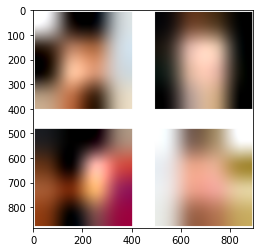

In [34]:
img = plt.imread('/tf/GAN/pggan_imgs/test_plot_weight_4x4_00000.png')
plt.imshow(img)
plt.show()

接下來就直接迴圈處理掉，把我們的模型推進到最終的256x256

In [35]:
for n_depth in range(1, 7): 
    # 權重名稱自己再確認一下自己訓練的時候是怎麼保存的
    # 以我的為例，就是單純的weight_fade_in_{n_depth}
    pggan.n_depth = n_depth
    
    prefix = f'weight_fade_in_{n_depth}'
    pggan.fade_in_generator()
    pggan.fade_in_discriminator()
    pggan.load_weights(prefix)
    
    pggan.stabilize_generator()
    pggan.stabilize_discriminator()
    prefix = f'weight_{n_depth}'
    pggan.load_weights(prefix)
    save_sample(pggan.generator, random_latent_vectors, prefix)

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
pixel_normalization_8 (PixelNor (None, 512)          0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 8192)         4194304     pixel_normalization_8[0][0]      
__________________________________________________________________________________________________
weight_scaling_20 (WeightScalin (None, 8192)         0           dense_5[0][0]                    
__________________________________________________________________________________________

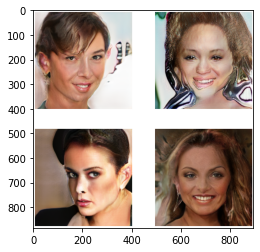

In [36]:
img = plt.imread('/tf/GAN/pggan_imgs/test_plot_weight_6_00000.png')
plt.imshow(img)
plt.show()

下面測試做插值

In [44]:
sample_0 = tf2.random.normal(shape=[4, 512], seed=338)
sample_1 = tf2.random.normal(shape=[4, 512], seed=449)

In [45]:
steps = 120
dt = (sample_0 - sample_1) / steps
for i in range(1, steps+1):
    random_latent_vectors = sample_0 + dt * i
    prefix = f'inter_{i:03d}'
    save_sample(pggan.generator, random_latent_vectors, prefix)


 saved /tf/GAN/pggan_imgs/test_plot_inter_001_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_002_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_003_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_004_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_005_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_006_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_007_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_008_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_009_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_010_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_011_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_012_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_013_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_014_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_015_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_016_00000.png

 saved /tf/GAN/pggan_imgs/test_plot_inter_017_00000.png

 saved /tf/GAN/pggan_imgs/test

以上，大致就是PGGAN的流程

總結，可以繼續再訓練下去，有機會直接訓練到1024x1024，看起來效果應該不錯。